# **Tic-Tac-Toe Classification Model**

### 1. Title: Tic-Tac-Toe Endgame database

### 2. Source Information
   -- Creator: David W. Aha (aha@cs.jhu.edu)
   -- Donor: David W. Aha (aha@cs.jhu.edu)
   -- Date: 19 August 1991
 
### 3. Known Past Usage: 
   1. Matheus,~C.~J., \& Rendell,~L.~A. (1989).  Constructive
      induction on decision trees.  In {\it Proceedings of the
      Eleventh International Joint Conference on Artificial Intelligence} 
      (pp. 645--650).  Detroit, MI: Morgan Kaufmann.
      -- CITRE was applied to 100-instance training and 200-instance test
         sets.  In a study using various amounts of domain-specific
         knowledge, its highest average accuracy was 76.7% (using the
         final decision tree created for testing).

   2. Matheus,~C.~J. (1990). Adding domain knowledge to SBL through
      feature construction.  In {\it Proceedings of the Eighth National
      Conference on Artificial Intelligence} (pp. 803--808). 
      Boston, MA: AAAI Press.
      -- Similar experiments with CITRE, includes learning curves up
         to 500-instance training sets but used _all_ instances in the
         database for testing.  Accuracies reached above 90%, but specific
         values are not given (see Chris's dissertation for more details).

   3. Aha,~D.~W. (1991). Incremental constructive induction: An instance-based
      approach.  In {\it Proceedings of the Eighth International Workshop
      on Machine Learning} (pp. 117--121).  Evanston, ILL: Morgan Kaufmann.
      -- Used 70% for training, 30% of the instances for testing, evaluated
         over 10 trials.  Results reported for six algorithms:
         -- NewID:   84.0%
         -- CN2:     98.1%  
         -- MBRtalk: 88.4%
         -- IB1:     98.1% 
         -- IB3:     82.0%
         -- IB3-CI:  99.1%
      -- Results also reported when adding an additional 10 irrelevant 
         ternary-valued attributes; similar _relative_ results except that
         IB1's performance degraded more quickly than the others.

### 4. Relevant Information:

   This database encodes the complete set of possible board configurations
   at the end of tic-tac-toe games, where "x" is assumed to have played
   first.  The target concept is "win for x" (i.e., true when "x" has one
   of 8 possible ways to create a "three-in-a-row").  

   Interestingly, this raw database gives a stripped-down decision tree
   algorithm (e.g., ID3) fits.  However, the rule-based CN2 algorithm, the
   simple IB1 instance-based learning algorithm, and the CITRE 
   feature-constructing decision tree algorithm perform well on it.

### 5. Number of Instances: 958 (legal tic-tac-toe endgame boards)

### 6. Number of Attributes: 9, each corresponding to one tic-tac-toe square

### 7. Attribute Information: (x=player x has taken, o=player o has taken, b=blank)

    1. top-left-square: {x,o,b}
    2. top-middle-square: {x,o,b}
    3. top-right-square: {x,o,b}
    4. middle-left-square: {x,o,b}
    5. middle-middle-square: {x,o,b}
    6. middle-right-square: {x,o,b}
    7. bottom-left-square: {x,o,b}
    8. bottom-middle-square: {x,o,b}
    9. bottom-right-square: {x,o,b}
    10. Class: {positive,negative}

### 8. Missing Attribute Values: None

### 9. Class Distribution: About 65.3% are positive (i.e., wins for "x")

### **Import Standard Packages and Libraries**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Ignore the Warnings
from warnings import filterwarnings
filterwarnings("ignore")

### **Read the Dataset into a Dataframe**

In [2]:
tic = pd.read_csv("tic-tac-toe.data", header=None)
tic.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [3]:
cols = {0:"top-left-square", 1:"top-middle-square", 2:"top-right-square", 3:"middle-left-square", 4:"middle-middle-square", 
           5:"middle-right-square", 6:"bottom-left-square", 7:"bottom-middle-square", 8:"bottom-right-square", 9:"Class"}
tic1 = tic.rename(columns=cols)
tic2 = tic1.replace('positive',1)
tictac = tic2.replace('negative',0)
tictac.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,1
1,x,x,x,x,o,o,o,x,o,1
2,x,x,x,x,o,o,o,o,x,1
3,x,x,x,x,o,o,o,b,b,1
4,x,x,x,x,o,o,b,o,b,1


### **Data Inspection**

In [4]:
tictac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   top-left-square       958 non-null    object
 1   top-middle-square     958 non-null    object
 2   top-right-square      958 non-null    object
 3   middle-left-square    958 non-null    object
 4   middle-middle-square  958 non-null    object
 5   middle-right-square   958 non-null    object
 6   bottom-left-square    958 non-null    object
 7   bottom-middle-square  958 non-null    object
 8   bottom-right-square   958 non-null    object
 9   Class                 958 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 75.0+ KB


In [5]:
tictac.isna().sum()

top-left-square         0
top-middle-square       0
top-right-square        0
middle-left-square      0
middle-middle-square    0
middle-right-square     0
bottom-left-square      0
bottom-middle-square    0
bottom-right-square     0
Class                   0
dtype: int64

#### *There are no NaN values in the dataset.*

In [6]:
tictac.describe(include=['object'])

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
count,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3
top,x,x,x,x,x,x,x,x,x
freq,418,378,418,378,458,378,418,378,418


In [7]:
tictac.describe()

,Class
count,958.000000
mean,0.653445
std,0.476121
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


#### *We have 958 rows of 9 feature variables and 1 target variable. All the variables are categorical*

### **Visualization of Dataframe**

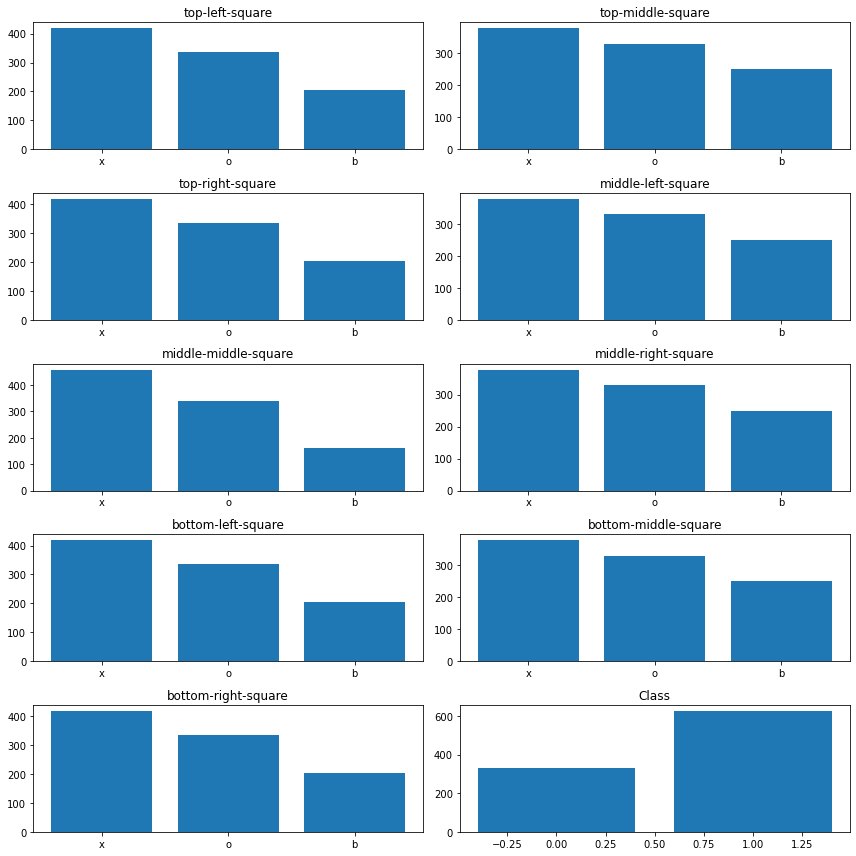

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12)) # Set the rows, columns and size of the subplots
plt.subplots_adjust(hspace = 0.8, top=0.4, bottom=0.1) # Adjust the spacing between subplots

i, j = 0,  0 # Initialize i and j variables

# Loop Start for plotting of all the columns
# Here we are plotting Bar plots of all the columns wrt Count.
for col in tictac.columns:
    s = tictac[col].value_counts()
    axs[i, j].bar(list(s.index.values), s.to_numpy()) # Plot the barplots of all the columns
    axs[i, j].set_title(col) # Set the title of each subplot to column names
     
    j +=1 # Increment the Inner counter
    
    if j%2 == 0: # Each Row will display only 2 columns. Once the number of columns is reached 2, Counter will be reset to zero
        i +=1
        j = 0
        
fig.tight_layout() # Display the plots properly
plt.show() # Show the plots

### **Observations**
- All variables except Class variable tell the moves which were made.
- Class value 'positive' tells the number of wins for 'x' assuming that 'x' is played first.

### Let's convert Categorical columns into numeric columns

In [9]:
cols = tictac.select_dtypes(include=['object']).columns # Identify the Categorical columns
data = pd.get_dummies(tictac, columns = cols) # Encode the columns
#encoder = OneHotEncoder()
#data = encoder.fit_transform(tictac[cols])
data.head() # Display the dataframe

,Class,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


### **Identify the X (Features) and y (Target) variables**

In [13]:
X = data.drop('Class', axis =1) # Identify X Variables
y = data.Class # Identify y variables

## **Model 1: Random Forest Classifier Model**

### **Split the Data into Train, Validation and Test Sets for Random Forest Classifier Model**

In [14]:
# In order to split data into train, validation and test sets
# We'll be performing train_test_split twice. First, we'll split the data into train:test ratio of 70:30
# Further, we'll be splitting 70% of training data into 55% of training and 15% of validation set data.

#Split data into train and test
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size = 0.3, random_state=465) 
#Further, split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.105, random_state=465)

In [15]:
#Define number of trees and K folds
n_trees = range(5,13,3)
k_fold = range(2,5)

#Initialize placeholder variables to determine the best parameters of the model
best_score=0
scores_val=[]
number_trees=[]

#Loop for Model Creation and Evaluation
for i in n_trees:
    #Loop for K Fold
    for j in k_fold:
        rfc = RandomForestClassifier(n_estimators = i, random_state=465) # Invoke RandomForestClassifier model 
        rfc.fit(X_train, y_train) # Fit the model
        print(f"Display Results for K Fold: {j}") #Print the results for K Folds
        print("Tree #:",i,cross_val_score(rfc, X_train, y_train, cv=j)) # Display Cross Val Scores for different number of Trees
        
        # Evaluation of Mean Accuracy of Training Set
        print("Mean Accuracy for Training Set is: ", round(sum(cross_val_score(rfc, X_train, y_train, cv=4)/4)*100,2),"%") 
        score = rfc.score(X_val, y_val) # Evaluation of model on validation set
        print(f"Accuracy Score on Validation Set is {100*score:.2f}%\n") # Display the accuracies on validation set
        scores_val.append(score) # append the scores to an array
        if score >= best_score: # if statement to determine the best parameters of the model
            best_score=score
            best_params={'n_estimators' : i}
            
print("***********************************************")
print("All Validation Scores:",scores_val) # display all validation set accuracies
print(f"\nBest Accuracy Score: {100*best_score:.2f}%") # display the best accuracy on validation set

# display the parameters that generated the best accuracy on validation set
print(f"Best Parameters for Random Forest Classfier: {best_params}") 

Display Results for K Fold: 2
Tree #: 5 [0.77666667 0.81270903]
Mean Accuracy for Training Set is:  84.8 %
Accuracy Score on Validation Set is 92.96%

Display Results for K Fold: 3
Tree #: 5 [0.8        0.96       0.84422111]
Mean Accuracy for Training Set is:  84.8 %
Accuracy Score on Validation Set is 92.96%

Display Results for K Fold: 4
Tree #: 5 [0.83333333 0.86       0.87333333 0.82550336]
Mean Accuracy for Training Set is:  84.8 %
Accuracy Score on Validation Set is 92.96%

Display Results for K Fold: 2
Tree #: 8 [0.83       0.84615385]
Mean Accuracy for Training Set is:  88.32 %
Accuracy Score on Validation Set is 91.55%

Display Results for K Fold: 3
Tree #: 8 [0.825      0.95       0.88944724]
Mean Accuracy for Training Set is:  88.32 %
Accuracy Score on Validation Set is 91.55%

Display Results for K Fold: 4
Tree #: 8 [0.88666667 0.86666667 0.88       0.89932886]
Mean Accuracy for Training Set is:  88.32 %
Accuracy Score on Validation Set is 91.55%

Display Results for K Fol

### **Evaluation of RFC Model on Test Set**

In [16]:
# Test Set - Model Accuracy
rfc_best = RandomForestClassifier(**best_params, random_state=465) # Implementation of the model with best parameters
rfc_best.fit(X_train, y_train) # Fit the model
score = rfc_best.score(X_test, y_test) # Evaluate the model on test set
           
print(f"Accuracy Score: {100*score:.2f}%") # display the accuracies on test set

Accuracy Score: 94.44%


### **Confusion Matrix for Random Forest Classifier Model**

<Figure size 1080x864 with 0 Axes>

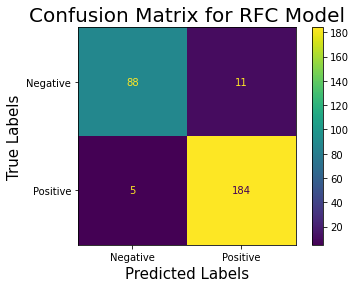

In [17]:
plt.figure(figsize=(15,12)) # Set the size of the plot
plot_confusion_matrix(rfc_best, X_test, y_test, display_labels=["Negative","Positive"]) # Plot the confusion Matrix
plt.title("Confusion Matrix for RFC Model", size=20) # Set the title of the plot
plt.xlabel("Predicted Labels", size=15) # Set x axis label
plt.ylabel("True Labels", size=15) # Set y axis label
plt.show() # Show the plot

## **Model 2: Gradient Boosting Classifier Model**

### **Split the Data into Train and Test Sets for Gradient Boosting Classifier Model and XGBoost Classifier Model**

In [18]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=465) 

In [19]:
#Initialize the ranges for maximum depth, maximum leaf nodes and minimum samples leaf.
depth=range(3,6,1)
leaf_node=range(10,21,2)
sample_leaf=range(10,26,2)

best_score=0

#For loop to build and fit the model
for i in depth:
    for j in leaf_node:
        for k in sample_leaf:
            #Build the model
            gbc = GradientBoostingClassifier(max_depth=i, max_leaf_nodes=j, min_samples_leaf=k, random_state=465)
            
            #Fit the model
            gbc.fit(X_train, y_train)
            
            #Evaluate and display the accuracies for training and test data
            accuracy_train = gbc.score(X_train, y_train)
            accuracy_test = gbc.score(X_test, y_test)
            
            if accuracy_test >= best_score:
                best_score=accuracy_test
                best_params={'max_depth': i, 'max_leaf_nodes' : j , 'min_samples_leaf': k}
            
print(f"Best Score is {100*best_score:.2f}%")
print(f"Best Params are {best_params}")

Best Score is 99.70%
Best Params are {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 20}


### **Creation of Gradient Boosting Classifier Model with Best Parameters**

In [20]:
gbc_best = GradientBoostingClassifier(**best_params, random_state=465) # Create GBC Model with Best parameters.
            
#Fit the model
gbc_best.fit(X_train, y_train)
            
#Evaluate and display the accuracies for training and test data
accuracy_train = gbc_best.score(X_train, y_train)
accuracy_test = gbc_best.score(X_test, y_test)
print(f"Accuracy Score of Training Data is {100*accuracy_train:.2f}%")
print(f"Accuracy Score of Test Data is {100*accuracy_test:.2f}%")

Accuracy Score of Training Data is 100.00%
Accuracy Score of Test Data is 99.70%


### **Confusion Matrix for Gradient Boosting Classifier Model**

<Figure size 1080x864 with 0 Axes>

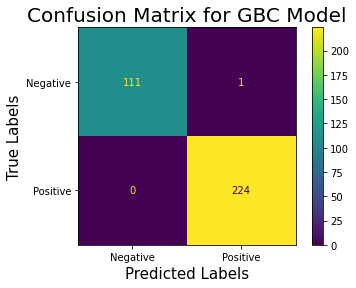

In [21]:
plt.figure(figsize=(15,12)) # Set the size of the plot
plot_confusion_matrix(gbc_best, X_test, y_test, display_labels=["Negative","Positive"]) # Plot the confusion Matrix
plt.title("Confusion Matrix for GBC Model", size=20) # Set the title of the plot
plt.xlabel("Predicted Labels", size=15) # Set x axis label
plt.ylabel("True Labels", size=15) # Set y axis label
plt.show() # Show the plot

## **Model 3: XGBClassifier Model**

In [22]:
xgb = XGBClassifier(random_state=465) # Invoke the model

# Define the parameter grid that is to be used in GridSearchCV
#Initialize the Grid Parameters
param_grid = {
    'max_depth' : range(3,6,1),
    'max_leaf_nodes' : range(10,21,2),
    'min_samples_leaf' : range(10,26,2)
}

# Apply GridSearchCV to identify the best parameters for XGBClassifier Model
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    cv=KFold(n_splits=4, random_state=465), verbose=0)

grid_result = grid.fit(X_train, y_train) # Fit the model
best_params = grid_result.best_params_ # Save the best parameters in a variable for later use

print(f'Best Score: {100*grid_result.best_score_:.2f}%') # Display best score
print(f'Best Params: {grid_result.best_params_}') # Display parameters which yielded best scores

Best Score: 97.43%
Best Params: {'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 10}


### **Build the XGBClassifier Model with Best Parameters**

In [23]:
xgb_best = XGBClassifier(**best_params, random_state=465, verbosity=0) # Invoke the XGBoost model with best parameters
xgb_best.fit(X_train, y_train) # FIt the model
score = xgb_best.score(X_test, y_test) # Evaluate the model on Test Set
           
print(f"Accuracy Score: {100*score:.2f}%") #Display the accuracy on test set

Accuracy Score: 97.62%


### **Confusion Matrix for XGBClassifier Model**

<Figure size 1080x864 with 0 Axes>

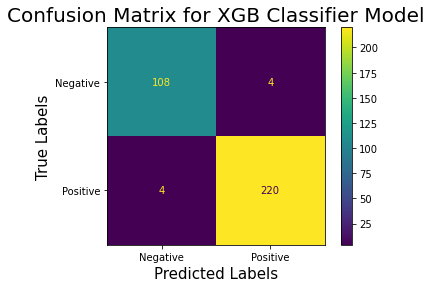

In [24]:
plt.figure(figsize=(15,12)) # Set the size of the plot
plot_confusion_matrix(xgb_best, X_test, y_test, display_labels=["Negative","Positive"]) # Plot the confusion Matrix
plt.title("Confusion Matrix for XGB Classifier Model", size=20) # Set the title of the plot
plt.xlabel("Predicted Labels", size=15) # Set x axis label
plt.ylabel("True Labels", size=15) # Set y axis label
plt.show() # Show the plot

### **Prediction**

In [48]:
df = pd.DataFrame({0:['x','x','x','o','b','x'],1:['o','x','o','b','b','o'],2:['b','x','x','o','b','o'],3:['b','x','b','o','x','b'],
                   4:['x','x','b','o','x','o'],5:['o','o','o','x','b','x'],6:['b','b','b','o','x','o'],7:['b','x','o','b','x','b'],8:['b','o','x','x','b','x']})
cols = {0:"top-left-square", 1:"top-middle-square", 2:"top-right-square", 3:"middle-left-square", 4:"middle-middle-square", 
           5:"middle-right-square", 6:"bottom-left-square", 7:"bottom-middle-square", 8:"bottom-right-square", 9:"Class"}
ticp = df.rename(columns=cols)
ticp.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,x,o,b,b,x,o,b,b,b
1,x,x,x,x,x,o,b,x,o
2,x,o,x,b,b,o,b,o,x
3,o,b,o,o,o,x,o,b,x
4,b,b,b,x,x,b,x,x,b


In [49]:
cols = ticp.select_dtypes(include=['object']).columns # Identify the Categorical columns
tic_p = pd.get_dummies(ticp, columns = cols) # Encode the columns
tic_p

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,0,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,1
4,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,1,0,0
5,0,0,1,0,1,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1


In [50]:
tic_p.shape

(6, 27)

In [57]:
tic_a = tic_p.to_numpy() # Display the dataframe
tic_a.shape

(6, 27)

In [59]:
#y_model_xgb = xgb_best.predict(tic_a)
#y_model_xgb

### **Prediction with GBC**

In [60]:
y_model_gbc = gbc_best.predict(tic_a)
y_model_gbc

array([1, 1, 1, 0, 1, 0], dtype=int64)

### **Prediction with RFC**

In [61]:
y_model_rfc = rfc_best.predict(tic_a)
y_model_rfc

array([1, 1, 1, 0, 1, 0], dtype=int64)